# Recommendation system for the block "You may like it".

This recommedation system is user-based system and it uses pearson correlation to find the nearest clients and then to recommend some of their assets.
The system is based on two types of the input data: 
1. data with fixed amount of features (total_portfolio, trading_volume, age, gender, user_type)
2. data with users positions (there could be any number of active positions in the client portfolio)

For the first type of data we normalise our data using min-max scaling. Then we get some input data for the test user who needs assets recommendation. We normalise this user's data using min-max scaling with minimum/maximums from the original dataset. Then we calculate pearson correlation in order to find similarity between clients.

For the second type of data we merge our test user positions with each user from the original dataset and calculate pearson correlation between weights of this common positions. In order to prevent the situation, for instance, if 2 common positions have higher correlation then 15 common positions by accident, we will multiply correlation with number of common positions.

For example, test user has 20 positions. Also, we have Bob and Alice from the original dataset. The number of shared positions between test user and Bob is 2 (for instance Tesla and Apple) and correlation between its weights is 0.4. But it's just 2 shared positions from 20 positions of the test user. On the other hand, the number of shared positions between the test user and Alice is 12. But the correlation between these 12 weights is 0.3. It seems lower, but there are 12 shared positions!

Previously, I thought about using p-value for the penalty function ${P(x) = r / p}$-${value}$. But it doesn't work as I predicted because p-value could be very close to zero, and if we divide correlation with p-value there will be extremely high score value. So I've decided to use the number of positions: ${P(x) = r * n_{positions}}$. 
For the given example, score for Bob is ${0.4 * 2 = 0.8}$ and score for Alice is ${0.3 * 12 = 3.6}$.

Then we normalise these scores using min-max scaling.

Import some necessery libraries.
recom_sys_data is a module for downloading the data about users. It's sensitive date, so I've decided to leave data preparation under the hood.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import recom_sys_data

The first block of our data:

In [2]:
first_block = recom_sys_data.get_data(first_part=True)
first_block.head()

,total_portfolio,trading_volume,age,other,promo,ref,female,male
user_id,,,,,,,,
167,0.000,589.55,31.0,1,0,0,0,1
176,0.000,413.13,47.0,1,0,0,0,1
178,79.302,78.49,32.0,1,0,0,0,1
228,0.000,193.87,32.0,1,0,0,1,0
262,0.000,399.56,27.0,1,0,0,0,1


Delete the highest 1% of total portfolio like outliers.

In [3]:
first_block = first_block[
    first_block.total_portfolio < first_block.total_portfolio.quantile(q=0.99)]

Save information about minimum and maximum values from our dataset to be able to scale our input user.
And then scale our dataset.

In [4]:
min_max = {
    'min': first_block.iloc[:, :-1].min().to_dict(),
    'max': first_block.iloc[:, :-1].max().to_dict()
}

# scale our data
scaler = MinMaxScaler()
first_block = pd.DataFrame(scaler.fit_transform(first_block),
                               columns=first_block.columns,
                               index=first_block.index)

first_block.head()

,total_portfolio,trading_volume,age,other,promo,ref,female,male
user_id,,,,,,,,
167,0.000000,0.010421,0.191176,1.0,0.0,0.0,0.0,1.0
176,0.000000,0.007301,0.426471,1.0,0.0,0.0,0.0,1.0
178,0.040812,0.001383,0.205882,1.0,0.0,0.0,0.0,1.0
228,0.000000,0.003424,0.205882,1.0,0.0,0.0,1.0,0.0
262,0.000000,0.007061,0.132353,1.0,0.0,0.0,0.0,1.0


Let's create some test user for recommendation. I've made the special method get_test_user for this:

In [5]:
dude = recom_sys_data.get_test_user()
dude

,total_portfolio,trading_volume,age,other,promo,ref,female,male
101,500,565,35,1,0,0,0,1


So the have some 35 years old male dude with total portfolio 500 GBP.
Let's scale his information using our saved min/max values from the original dataset:

In [6]:
def scale_input(input_data, min_max):
    features_to_scale = ['total_portfolio', 'trading_volume', 'age']
    for feature in features_to_scale:
        input_data[feature].iloc[0] = \
            (input_data[feature].iloc[0] - min_max['min'][feature]) \
                / (min_max['max'][feature] - min_max['min'][feature])

    return input_data


scale_input(dude, min_max)

/Users/olegustimenko/Desktop/venv/venv_orca/lib/python3.10/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,total_portfolio,trading_volume,age,other,promo,ref,female,male
101,0.25732,0.009986,0.25,1,0,0,0,1


And now we can calculate the correlation coeficient between our dude and each user from the original dataset. I use cdist (correlation distance) from scipy.spatial.distance module because it's more efficient way to calculate correcation than using numpy.corrcoef.

In [7]:
corr = 1 - cdist(dude.values, first_block.values, metric='correlation')[0]
index = first_block.index
first_correlation = pd.DataFrame(corr, index=index, columns=['first_correlation'])
first_correlation.describe()

,first_correlation
count,7703.000000
mean,0.112840
std,0.429412
min,-0.514670
25%,-0.454393
50%,0.257400
75%,0.260769
max,0.999878


So, we have correlations between each user and our dude. The first similarity sign is ready. Let's go to the second part of our recommendation model!

Get the second block of data with positions and weights:

In [8]:
second_block = recom_sys_data.get_data(first_part=False)
second_block.head()

,user_id,symbol_id,position_weight
0,178,608,0.071146
1,178,735,0.138269
2,178,567,0.765365
3,323,929,0.104101
4,323,940,0.137587


We should group our data by user_id because we will merge our positions individually for each user with dude

In [9]:
second_block_grouped = second_block.groupby('user_id')

The example our some user from the second block:

In [10]:
second_block[second_block.user_id == 2439].head()

,user_id,symbol_id,position_weight
96,2439,521,0.034998
97,2439,556,0.036212
98,2439,536,0.029307
99,2439,530,0.037765
100,2439,577,0.021794


It's time to get dude's positions:

In [11]:
dudes_pos = recom_sys_data.get_test_user(positions=True)
dudes_pos

,dudes_id,dudes_symbol_id,dudes_position_weight
0,101,670,0.01
1,101,735,0.01
2,101,941,0.14
3,101,1053,0.04
4,101,611,0.01
5,101,636,0.03
6,101,926,0.02
7,101,936,0.26
8,101,515,0.29
9,101,667,0.10


The test merge with some user from the dataset using symbol_id field:

In [12]:
data = dudes_pos.iloc[:, 1:].merge(
    second_block_grouped.get_group(178).iloc[:, 1:], left_on='dudes_symbol_id', right_on='symbol_id')
data

,dudes_symbol_id,dudes_position_weight,symbol_id,position_weight
0,735,0.01,735,0.138269


So now we should created a function to calculate score of similarity: correlation * number of shated positions.
Then we itteratively calculate score for each user from the second block of data and save it:

In [13]:
def get_score(control_weights: list, user_weights: list) -> int:
    """
    Both control_weights and user_weights are weights of shated positions
    between two client's portfolios
    """
    # append weight of cash in portfolio as 1 - sum of positions weights
    control_weights = np.append(control_weights, 1 - control_weights.sum())
    user_weights = np.append(user_weights, 1 - user_weights.sum())
    # calc correlation between weights
    correlation = np.corrcoef(control_weights, user_weights)[0][1]
    # calc number of positions including cash
    # because cash also could be an indicator of similarity
    n_positions = len(control_weights)
    # final score
    score = correlation * n_positions
    score = np.nan_to_num(score)
    return score


scores = np.array([])
for group in second_block_grouped.groups:
    # merge dudes positions with other user
    data = dudes_pos.iloc[:, 1:].merge(
        second_block_grouped.get_group(group).iloc[:, 1:],
        left_on='dudes_symbol_id', right_on='symbol_id')
    scores = np.append(scores, get_score(data.position_weight, data.dudes_position_weight))


# min-max scaling of our score to be between 0 and 1
def minmax_scale(list_of_values: np.array) -> np.array:
    min_value = list_of_values.min()
    max_value = list_of_values.max()
    for i in range(len(list_of_values)):
        list_of_values[i] = (list_of_values[i] - min_value) / (max_value - min_value)

    return list_of_values


minmax_scale(scores)
scores.min(), scores.max()

/Users/olegustimenko/Desktop/venv/venv_orca/lib/python3.10/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/olegustimenko/Desktop/venv/venv_orca/lib/python3.10/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/olegustimenko/Desktop/venv/venv_orca/lib/python3.10/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


(0.0, 1.0)

Distribution of our scaled scores:

(array([1.000e+00, 4.000e+00, 2.470e+02, 4.000e+00, 4.568e+03, 1.800e+01,
        1.106e+03, 8.300e+01, 8.000e+00, 1.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

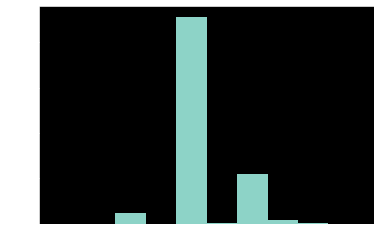

In [14]:
plt.hist(scores)

Let's make DataFrame for the second correlation:

In [15]:
second_correlation = pd.DataFrame(scores, index=second_block_grouped.groups.keys(), columns=['second_correlation'])
second_correlation.index.name = 'user_id'
second_correlation.head()

,second_correlation
user_id,
178,0.611267
323,0.611267
325,0.430791
335,0.701449
360,0.611267


Now we can join our the first correlation with the second correlation in order to calculate an average score for each user. I use left join type because not each user has some positions in its portfolio so I fill its second correlation with dude as zero:

In [16]:
# joining and filling with zero
correlation = first_correlation.join(second_correlation, how='left').fillna(0)
# calculation of average score between the first correlation and the second correlation
correlation['average_score'] = (correlation.first_correlation + correlation.second_correlation) / 2
correlation.sort_values(by='average_score', ascending=False).head()

,first_correlation,second_correlation,average_score
user_id,,,
3492,0.984889,0.791093,0.887991
7307,0.987256,0.767023,0.877139
17373,0.976909,0.775146,0.876028
25072,0.988970,0.759100,0.874035
16311,0.955967,0.790777,0.873372


Finally, we have score of dude's similarity for each user. What's the next step? For each position's weight from the second block of data we should multiplu it with final score to get some weight of positions taking into account the final score. The idea is the bigger weight of some symbol and the higher similarity score the better to recommend this symbol for user.
So, after multiplying each position with user's score I will sum up all this values grouped by symbol_id to get some final score for each symbol_id to recommend to dude.

In [17]:
final_score = second_block.set_index('user_id').join(correlation, how='left')
final_score['position_score'] = final_score.position_weight * final_score.average_score
final_score.dropna(inplace=True)
final_score = final_score.groupby('symbol_id').position_score.sum().sort_values(ascending=False)
final_score.head()

symbol_id
729    72.810986
545    69.375804
584    68.657213
549    60.948362
674    52.911006
Name: position_score, dtype: float64

Hurray! We have final score for each symbol id to recommed to our dude! Let's drop the current dudes positions from the final scores and get top 10 symbols to recommend to dude:

In [18]:
positions_to_drop = dudes_pos.dudes_symbol_id.values
final_score[~final_score.index.isin(positions_to_drop)].head(10).index

Int64Index([729, 545, 584, 549, 674, 567, 544, 622, 983, 737], dtype='int64', name='symbol_id')

Let's see what are these symbol ids:

In [19]:
recom_symbols = final_score[~final_score.index.isin(positions_to_drop)].head(10).index.to_list()

In [20]:
print(recom_sys_data.get_symbol_id_info(recom_symbols))

  ticker name          isin
0   CTEC       GB00BD3VFW73
1   TWTR       US90184L1026
2   TSCO       GB00BLGZ9862
3    TUI       DE000TUAG000
4    RR.       GB00B63H8491
5   LGEN       GB0005603997
6   LLOY       GB0008706128
7    MNG       GB00BKFB1C65
8   HMSO       GB00BK7YQK64
9    BOO       JE00BG6L7297


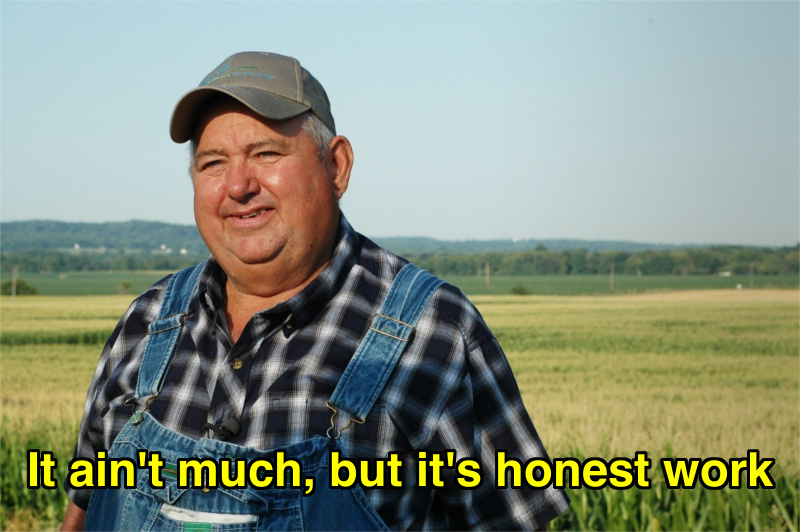

In [6]:
from IPython.display import Image

Image("But_Its_Honest_Work.png", width=1000, height=1000)